# Тестовое задание на позицию DS'а

## Описание датасета

В этом задании предлагается классифицировать сообщения на предмет того, из какого чата они были взяты. Датасет представляет собой сообщения участников двух публичных чатов:
* Чат по Python (label=0)
* Чат по Data Science (label=1)

## Описание задачи

Ваша задача:
1. Сделать предобработку текстов
2. Предложить модель классификации, метрики.
3. Объяснить их выбор (достоинства/недостатки). 
4. Сделать выводы по работе модели(ей) (достоинства/недостатки), а также проблемы, с которыми вы или ваша модель столкнулась.

Было бы интересно посмотреть не только на финальное решение, но и на эксперименты (даже провальные). 

## Загрузка данных

In [3]:
import time

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

df = pd.read_csv('train.csv')
df.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,label
884,"ну вон как технлогии зашли, из одного числа 2 даты вытягивать можно",1
9451,"можешь накосячить с индексом, выйти из массива и т п",0
7816,у меня есть отличная идея на скор 0.69 ),1
8607,он же сказал что задача может быть сложнее. так что мы тут рассуждаем больше теоретически.,0
3899,а если документирвоать словами что ожидает метод и что возвращает?,0


## Ваше решение

## Checking the distribution of classes

In [5]:
# first of all we should preprocess the data(for text - tokenization and lemmatization(or stemming))

X = df.loc[:,'text']
# 0 - python, 1 - satan
Y = df.loc[:,'label']
print(X.shape)

(12404,)


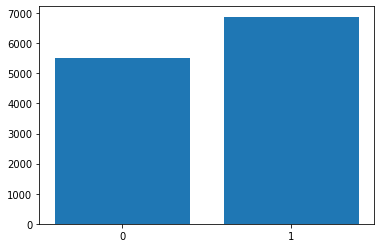

In [6]:
import matplotlib.pyplot as plt
labels = ['0','1']
ones = sum(Y)
zeros = Y.shape[0]-ones
plt.bar(labels,(zeros,ones))
plt.show()

## Preparing class for text preprocessing(required for first and second approaches)

In [7]:
!pip install razdel
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 10.3 MB/s 


In [8]:
# natasha tokenizer
from razdel import tokenize

# lemmatizer(originally i tried pymystem, but it did not work in colab for some reason)
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# stop words do not add any information to classification task
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words('russian')


from string import punctuation

class Preprocessor:
    '''
    takes as input raw sentence and does tokenization + lemmatization
    '''

    def __init__(self,tokenizer = tokenize, lemmatizer = morph,stopwords = russian_stopwords):
        # other tokenizer and lemmatizer might be used, code should be modified in that case, cause their returns differ
        self.tokenizer = tokenizer
        self.lemmatizer = lemmatizer
        self.stopwords = stopwords

    def prep(self,sentence):
        # tokenize:
        # # tokenize returns tuple of [start of seq pos, end of seq pos, token],
        tokens = [_.text for _ in self.tokenizer(sentence)]

        # lemmatize ()
        lemmas = [self.lemmatizer.parse(word)[0].normal_form for word in tokens]

        # remove unnecessary tokens
        prep_tokens = [word for word in lemmas if word not in self.stopwords 
                                                and word.strip() not in punctuation
                                                and word != ' ']

        return prep_tokens



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
preprocessor = Preprocessor()
preprocessor.prep('идем завтра гулять')

['идти', 'завтра', 'гулять']

In [10]:
prep_X = []
for i in range(X.shape[0]):
    prep_text = preprocessor.prep(X[i])
    prep_X.append(prep_text)

## Machine learning

###Approach 1. Pretrained glove for embeddings + classifier

In [11]:
#APPROACH 1: glove navec + classifier
!pip install navec

!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_pretrained.tar

--2021-09-01 16:59:55--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_pretrained.tar’

navec_pretrained.ta 100%[===================>]  50.56M  16.3MB/s    in 3.3s    

2021-09-01 16:59:59 (15.4 MB/s) - ‘navec_pretrained.tar’ saved [53012480/53012480]



In [12]:
from navec import Navec


path = 'navec_pretrained.tar'
navec = Navec.load(path)


In [13]:
# represent sentence embedding as sum of it's tokens embeddings
def vectorize(sentence):
    dim = navec.pq.dim
    embedding = np.zeros([dim])

    for word in sentence:
        if word in navec:
            embedding += navec[word]

    return embedding

In [14]:
from sklearn.model_selection import train_test_split


X_vectorized = np.stack([vectorize(sent) for sent in prep_X])

X_train, X_test, Y_train, Y_test = train_test_split(X_vectorized, Y, test_size=0.2, random_state=0)


#### Logistic regression

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# sigmoid
clf = LogisticRegression(max_iter=5000)
wv_model = clf.fit(X_train, Y_train)
accuracy_score(Y_test, wv_model.predict(X_test))

0.7251108424022572

#### Support vector machine

In [16]:
# support vector machine
from sklearn import svm
svc = svm.SVC()
svc.fit(X_train, Y_train)

accuracy_score(Y_test, svc.predict(X_test))

0.7331721080209593

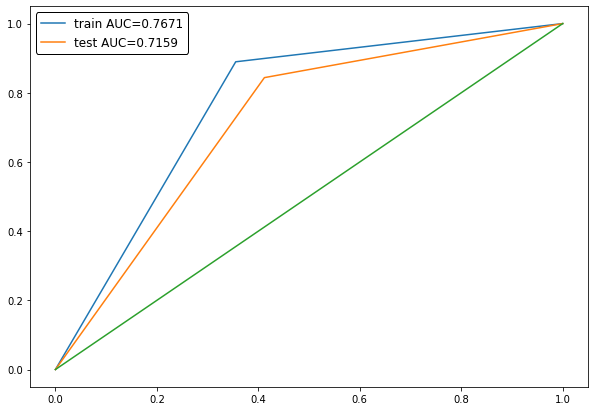

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Y_train_predicted = svc.predict(X_train)
Y_test_predicted = svc.predict(X_test)

train_auc = roc_auc_score(Y_train, Y_train_predicted)
test_auc = roc_auc_score(Y_test, Y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(Y_train, Y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(Y_test, Y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

####Benchmark(time) for SVM

In [18]:
# benchmarking inference time(full pipeline with tokenization, lemmatization, vectorization and classification)

start = time.time()

# tokenize + lemmatize
prep_X = []
for i in range(X.shape[0]):
    prep_text = preprocessor.prep(X[i])
    prep_X.append(prep_text)

# vectorize
X_vectorized = np.stack([vectorize(sent) for sent in prep_X])

# classify
svc.predict(X_vectorized)
end = time.time()

print(f"{(end-start)}")

95.40883088111877


In [19]:
# saving model
import pickle

filename = 'finalized_model.sav'

pickle.dump(svc, open(filename, 'wb'))

In [20]:
# loading saved model back and checking that it has same accuracy
loaded_model = pickle.load(open(filename, 'rb'))
accuracy_score(Y_test,loaded_model.predict(X_test))


0.7331721080209593

#### Boosting(Catboost by yandex)

In [22]:
!pip install catboost
import catboost

     |████████████████████████████████| 67.4 MB 26 kB/s 


In [23]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200)

boosting_model.fit(X_train, Y_train)

accuracy_score(Y_test, boosting_model.predict(X_test))

Learning rate set to 0.120076
0:	learn: 0.6780603	total: 178ms	remaining: 35.5s
1:	learn: 0.6641572	total: 316ms	remaining: 31.2s
2:	learn: 0.6536438	total: 425ms	remaining: 27.9s
3:	learn: 0.6440252	total: 546ms	remaining: 26.8s
4:	learn: 0.6352971	total: 652ms	remaining: 25.4s
5:	learn: 0.6279450	total: 768ms	remaining: 24.8s
6:	learn: 0.6214733	total: 876ms	remaining: 24.1s
7:	learn: 0.6157594	total: 992ms	remaining: 23.8s
8:	learn: 0.6096510	total: 1.11s	remaining: 23.5s
9:	learn: 0.6048093	total: 1.23s	remaining: 23.3s
10:	learn: 0.6005073	total: 1.33s	remaining: 22.9s
11:	learn: 0.5958846	total: 1.44s	remaining: 22.6s
12:	learn: 0.5930494	total: 1.55s	remaining: 22.4s
13:	learn: 0.5897571	total: 1.66s	remaining: 22.1s
14:	learn: 0.5859432	total: 1.77s	remaining: 21.8s
15:	learn: 0.5826922	total: 1.88s	remaining: 21.7s
16:	learn: 0.5798448	total: 1.99s	remaining: 21.4s
17:	learn: 0.5773290	total: 2.11s	remaining: 21.3s
18:	learn: 0.5747409	total: 2.22s	remaining: 21.2s
19:	learn: 

0.7222893994357114

###Approach 2. Recurrent neural network

In [24]:
vocab_size = navec.pq.shape[0]

In [25]:
vocab_size

500002

In [26]:
def encode(word):
    # if word in vocab it is equal to it's index
    if word in navec:
        return navec.vocab[word]
    return navec.vocab["<unk>"]



In [27]:
from torch.utils.data import Dataset, DataLoader

class chat_dataset(Dataset):
    def __init__(self,x=prep_X,y=Y):
        self.features = x
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        # encod
        sent = torch.tensor([encode(word) for word in self.features[idx]])
        label = self.labels[idx]

        return {'features':sent, 'labels':label}


X_train, X_test, Y_train, Y_test = train_test_split(prep_X, np.array(Y), test_size=0.2, random_state=0)



train_dataset = chat_dataset(x=X_train,y=Y_train)
test_dataset = chat_dataset(x=X_test,y=Y_test)


In [28]:
def collate_fn(batch):
    max_len = max(len(row["features"]) for row in batch)
    input_embeds = torch.empty((len(batch), max_len), dtype=torch.long)
    labels = torch.empty(len(batch), dtype=torch.long)
    # print(input_embeds.shape)
    # print(labels.shape)
    for idx, row in enumerate(batch):
        to_pad = max_len - len(row["features"])
        # print(row['features'])
        input_embeds[idx] = torch.cat((row["features"], torch.zeros(to_pad)))
        labels[idx] = row["labels"]
    return {"features": input_embeds, "labels": labels}

In [29]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


BATCH_SIZE = 4

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,collate_fn=collate_fn
                                        )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,collate_fn=collate_fn
                                        )

In [59]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size,embed_size, hidden_size, num_classes=2,n_layers=2,bidirectional=True):
        '''
        bidirectional with 2 layers(in comparison to previous model)
        '''
        super().__init__()
        self.bidirectional=bidirectional
        self.n_layers=2
        self.hid_dim=hidden_size


        self.embeddings = nn.Embedding(vocab_size, embed_size)
        # self.rnn = nn.RNN(embed_size, hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size,num_layers = n_layers, bidirectional=bidirectional,batch_first=True)
        self.cls = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        x = self.embeddings(x)

        output, hidden = self.rnn(x)
        # output = [batch_size, seq_length, n_directions*hidden_size], 
        # hidden = [n_directions*n_layers, batch_size, hidden_size], 

        # batch_size=4, bidirectional=True, n_layers=2
        # input.shape: torch.Size([4, 12])
        # hidden.shape: torch.Size([4, 4, 50])
        # output.shape: torch.Size([4, 12, 100]) 

        # batch_size=4, bidirectional=False, n_layers=1
        # input.shape: torch.Size([4, 18])
        # hidden.shape: torch.Size([1, 4, 50])
        # output.shape: torch.Size([4, 18, 50])

        if self.bidirectional:
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
            # hidden = [n_layers,n_directions,batch_size,hidden_size]

            hidden = hidden.transpose(1,2).reshape(self.n_layers,-1,2*self.hid_dim)
            # hidden = [n_layers, batch_size,hidden_size*2]


        # print(hidden.shape)
        # print(output.shape)

        # take only last layer
            output = self.cls(hidden[1])
        else:
            output, hidden = self.rnn(x)
            output = self.cls(hidden[0])

        return output

In [32]:

# these dicts are necessary for pretuning embedding layer with values from navec
word2_idx = {}
for sent in prep_X:
    for token in sent:
        if token not in word2_idx and token in navec:
            word2_idx[token] = navec.vocab[token]

idx2_word = {v:k for k,v in word2_idx.items()}



In [33]:
print(list(word2_idx.items())[:10])
print(list(idx2_word.items())[:10])

[('верхний', 56993), ('предел', 330813), ('поинт', 313808), ('это', 496312), ('проблема', 344061), ('ага', 16057), ('паркинг', 287323), ('пул', 355878), ('подобный', 309148), ('сайт', 384240)]
[(56993, 'верхний'), (330813, 'предел'), (313808, 'поинт'), (496312, 'это'), (344061, 'проблема'), (16057, 'ага'), (287323, 'паркинг'), (355878, 'пул'), (309148, 'подобный'), (384240, 'сайт')]


In [34]:
emb_size = navec.pq.shape[1]
hid_size = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

vocab_size = navec.pq.shape[0]
model = RNNModel(vocab_size,emb_size,hid_size).to(device)

# PAD_IDX = 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 3

In [57]:
from tqdm.notebook import tqdm, trange
def training(model, criterion, optimizer, num_epochs, train_loader, test_loader, max_grad_norm=2):
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        pbar = tqdm(train_loader, leave=False)
        for batch in pbar:
            optimizer.zero_grad()
            input_embeds = batch["features"].to(device)
            labels = batch["labels"].to(device)
            # print(type(input_embeds))
            prediction = model(input_embeds)
            # print(prediction.shape)
            # print(labels.shape)
            loss = criterion(prediction, labels)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        valid_loss = 0
        valid_acc = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in test_loader:
                input_embeds = batch["features"].to(device)
                labels = batch["labels"].to(device)
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                correct += (labels == prediction.argmax(-1)).float().sum()
                num_objs += len(labels)
                num_iter += 1

        print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {correct/num_objs}")




#### Training the simplest approach: RNN+classifier

In [ ]:
training(model, criterion, optimizer, num_epochs, train_loader, test_loader, max_grad_norm=1)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.5835511088371277, accuracy: 0.7142281532287598


  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.6426441669464111, accuracy: 0.7476823925971985


  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.8643467426300049, accuracy: 0.7468762397766113


#### Initializing weights for embedding layer using weights from glove

In [ ]:
#changing weights of embedding layer with weights taken from navec

num_epochs = 2
pretuned_model = RNNModel(vocab_size,emb_size,hid_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretuned_model.parameters(), lr=1e-3)

n_pretrained_vecs = 0
with torch.no_grad():

    for i in range(pretuned_model.embeddings.weight.shape[0]):
        if i in idx2_word:
            n_pretrained_vecs +=1
            pretuned_model.embeddings.weight[i,:] = torch.tensor(navec[idx2_word[i]])

print(f"total number of pretrained embeddings: {n_pretrained_vecs}")

total number of pretrained embeddings: 12296


In [ ]:
training(pretuned_model, criterion, optimizer, num_epochs, train_loader, test_loader, max_grad_norm=1)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.4919772148132324, accuracy: 0.7718662023544312


  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.5239285230636597, accuracy: 0.7827488780021667


In [ ]:
# saving model parameters
model_path = 'rnn_pretrained.pt'
torch.save(pretuned_model.state_dict(), model_path)
pretuned_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

#### Testing RNN with second layer and bidirectionality

In [61]:
# testing rnn with bidirectionality and 2nd layer
num_epochs=3
improved_model = RNNModel2(vocab_size,emb_size,hid_size).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improved_model.parameters(), lr=1e-3)

n_pretrained_vecs = 0
with torch.no_grad():

    for i in range(improved_model.embeddings.weight.shape[0]):
        if i in idx2_word:
            n_pretrained_vecs +=1
            improved_model.embeddings.weight[i,:] = torch.tensor(navec[idx2_word[i]])

In [62]:
training(improved_model, criterion, optimizer, num_epochs, train_loader, test_loader, max_grad_norm=1)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.46193236112594604, accuracy: 0.786779522895813


  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.5736743211746216, accuracy: 0.7803305387496948


  0%|          | 0/2481 [00:00<?, ?it/s]

Valid Loss: 0.6976569294929504, accuracy: 0.7754937410354614


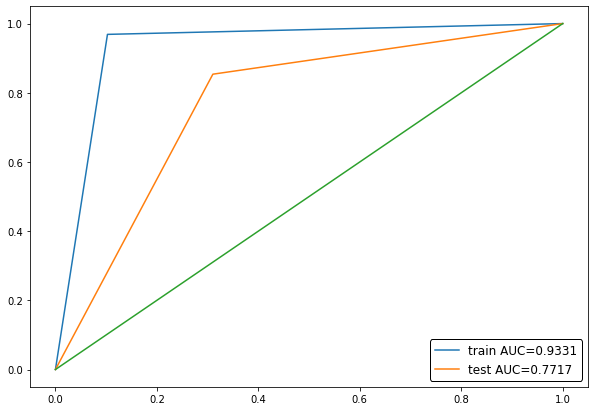

In [ ]:
# ROC AUC 


Y_train = []
Y_train_predicted = []
with torch.no_grad():

    for batch in train_loader:
        input_embeds = batch["features"].to(device)
        labels = batch["labels"].to(device)
        prediction = pretuned_model(input_embeds)
        
        prediction_argmax = torch.argmax(prediction,axis=1)
        Y_train.extend(labels.tolist())
        Y_train_predicted.extend(prediction_argmax.tolist())

Y_test = []
Y_test_predicted = []
with torch.no_grad():

    for batch in test_loader:
        input_embeds = batch["features"].to(device)
        labels = batch["labels"].to(device)
        prediction = pretuned_model(input_embeds)
        
        prediction_argmax = torch.argmax(prediction,axis=1)
        Y_test.extend(labels.tolist())
        Y_test_predicted.extend(prediction_argmax.tolist())

train_auc = roc_auc_score(Y_train, Y_train_predicted)
test_auc = roc_auc_score(Y_test, Y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(Y_train, Y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(Y_test, Y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### Benchmark(time)

In [ ]:
# benchmarking

start =time.time()
prep_X = []
for i in range(X.shape[0]):
    prep_text = preprocessor.prep(X[i])
    prep_X.append(prep_text)

full_dataset = chat_dataset(x = prep_X)

BATCH_SIZE = 4

full_loader = torch.utils.data.DataLoader(full_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,collate_fn=collate_fn
                                        )

pretuned_model.eval()
with torch.no_grad():

    for batch in full_loader:
        input_embeds = batch["features"].to(device)
        labels = batch["labels"].to(device)
        prediction = pretuned_model(input_embeds)

end = time.time()

print(f"{end-start}")

60.60068655014038


### Transformers(BERT) + logistic regression/fully connected neural network

In [63]:
##Transformers(BERT)

!pip install transformers

     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 34.2 MB/s 
     |████████████████████████████████| 636 kB 46.9 MB/s 
     |████████████████████████████████| 895 kB 48.0 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [64]:
import transformers

model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'DeepPavlov/rubert-base-cased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [65]:
model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [66]:
class chat_dataset_bert(Dataset):
    def __init__(self, features,labels, tokenizer):
        self.labels = labels
        # tokenized reviews
        self.tokenized = tokenizer([sent for sent in features])['input_ids']
        
    def __getitem__(self, idx):
        return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

dataset = chat_dataset_bert(df['text'].tolist(),df['label'].tolist(),tokenizer)

In [67]:
from torch.utils.data import random_split


train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 9923
Number of validation examples: 1240
Number of testing examples: 1241


In [68]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        '''
        in addition to sampling this samples does sorting of features according to their length, 
        thus less padding is required
        '''
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]


    def __iter__(self):

        batch_idx = []
        
        # sort sentences by their length
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                # print(batch_idx)
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [69]:
from torch.utils.data import DataLoader

def get_padded(values):
    # padding with zeroes
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])

    max_len = 0

    # padding to combine into matrix
    inputs = get_padded(inputs) 

    attention_mask = np.where(inputs>0,1,0)
    

    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), 'attention_mask' : torch.tensor(attention_mask)}



In [70]:
BATCH_SIZE = 4

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data,batch_size=BATCH_SIZE), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data,batch_size=BATCH_SIZE), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data,batch_size=BATCH_SIZE), collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


#### Using bert for feature extraction(pass sequence through bert and take only last layer's output, only first token which is <cls> token responsible for the whole sequence's embedding) and then passing that feature to logistic regression

In [ ]:
from tqdm.notebook import tqdm

def get_xy(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            
            # don't forget about .to(device)
            # print(batch['inputs'].shape)
            # print(batch['attention_mask'].shape)

            input = batch['inputs'].to(device)
            mask = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)

            if input.shape[1]>512:
                input = input[:,:512]
                mask = mask[:,:512]
            # print(input.shape)
            # print(mask.shape)

            
            last_hidden_states = model(input,attention_mask=mask)
            
            # last_hidden_state = [batch_size,seq_len,hidden_size]
            features.append(last_hidden_states[0].cpu())
            labels.append(label)

    # taking first element of sequence only(cls token):
    #(batch_size, seq_len, emb_dim) -> (batch_size, 1, emb_dim)
    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()
    labels = torch.cat(labels, dim=0).cpu().numpy()
    
    return features, labels

In [ ]:
train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.726027397260274

#### Using bert for feature extraction(taking first token of last layer) and passing it to linear neural network for classification 

In [ ]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.cls = nn.Sequential(
            nn.Linear(768,1),
            nn.Sigmoid()
        )

    def forward(self, inputs, attention_mask):
        
        last_hidden_states = self.bert(inputs,attention_mask=attention_mask)
        
        bert_out = self.relu(self.dropout(last_hidden_states[0])) #out = [batch_size,max_len,emb_dim]

        
        
        proba = self.cls(bert_out[:,0,:])[:,0]

        # features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()

        # proba = [batch_size, ] - probability to be positive
        return proba

In [ ]:
import torch.optim as optim

# DON'T CHANGE
model = model_class.from_pretrained(pretrained_weights).to(device)
bert_clf = BertClassifier(model).to(device)
# you can change
optimizer = optim.Adam(bert_clf.parameters(), lr=2e-5)
criterion = nn.BCELoss()

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        # don't forget about .to(device)
          
        input = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        if input.shape[1]>512:
            input = input[:,:512]
            mask = mask[:,:512]

        output = model(input,attention_mask = mask)

        # print(output.shape)
        # print(labels.shape)

        optimizer.zero_grad()
        
        loss = criterion(output, labels) 
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            input = batch['inputs'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            if input.shape[1]>512:
                input = input[:,:512]
                mask = mask[:,:512]
            output = model(input,attention_mask = mask)

            loss = criterion(output, labels)
            
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

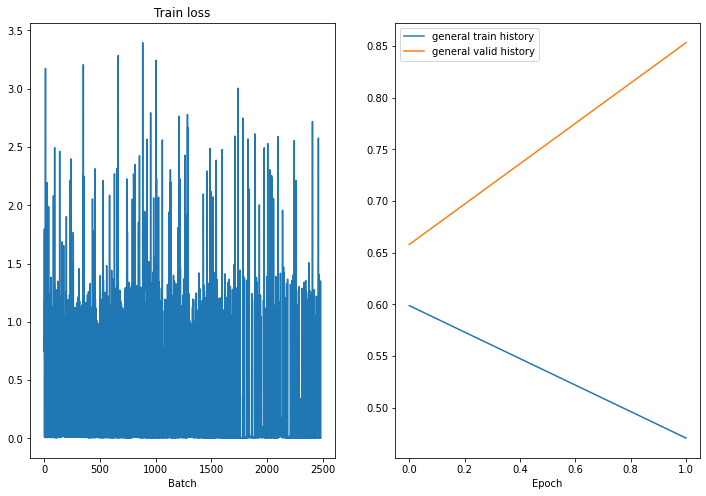

Epoch: 03 | Time: 10m 8s
	Train Loss: 0.324 | Train PPL:   1.383
	 Val. Loss: 1.177 |  Val. PPL:   3.246


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(bert_clf, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

pred_labels = []
true_labels = []

best_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        input = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        output = best_model(input,attention_mask = mask)

        # pred_label = np.argmax(output,axis=1)

        true_labels.append(labels.cpu().numpy())
        pred_labels.append(output.cpu().numpy())


0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score

# true_labels = np.concatenate(true_labels, axis=0)
# pred_labels = np.concatenate(pred_labels, axis=0)
pred_labels_thresholded = np.where(pred_labels>0.6,1.0,0.0)
accuracy_score(true_labels, pred_labels_thresholded)

0.860137041515518

#### Benchmark(time)

In [ ]:
#benchmarking bert

start = time.time()

# not 
dataset = chat_dataset_bert(df['text'].tolist(),df['label'].tolist(),tokenizer)
train_data, test_data = random_split(dataset, [train_size,len(dataset) - train_size ])

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data,batch_size=BATCH_SIZE), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data,batch_size=BATCH_SIZE), collate_fn=collate_fn)



BATCH_SIZE = 4



best_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(train_loader)):

        input = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if input.shape[1]>512:
            input = input[:,:512]
            mask = mask[:,:512]
        
        output = best_model(input,attention_mask = mask)

    for i, batch in tqdm(enumerate(test_loader)):

        input = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if input.shape[1]>512:
            input = input[:,:512]
            mask = mask[:,:512]
        
        output = best_model(input,attention_mask = mask)
    

end = time.time()

print(f"{end-start}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


0it [00:00, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
output

tensor([0.0138], device='cuda:0')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

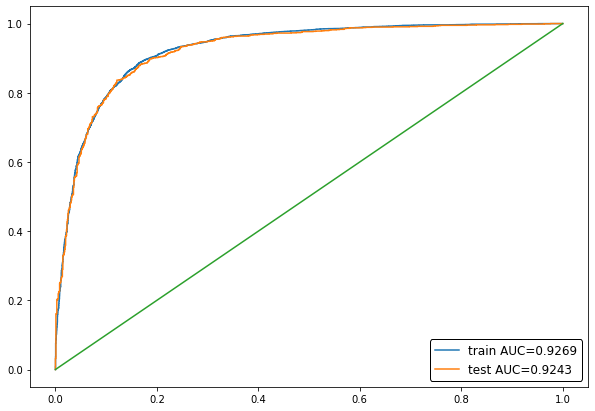

In [ ]:
Y_train = []
Y_train_predicted = []

Y_test = []
Y_test_predicted = []

# ROC AUC
with torch.no_grad():
    for i, batch in tqdm(enumerate(train_loader)):

        input = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if input.shape[1]>512:
            input = input[:,:512]
            mask = mask[:,:512]
        
        output = best_model(input,attention_mask = mask)

        Y_train.extend(labels.tolist())
        Y_train_predicted.extend(output.tolist())

    for i, batch in tqdm(enumerate(test_loader)):

        input = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if input.shape[1]>512:
            input = input[:,:512]
            mask = mask[:,:512]
        
        output = best_model(input,attention_mask = mask)

        Y_test.extend(labels.tolist())
        Y_test_predicted.extend(output.tolist())

train_auc = roc_auc_score(Y_train, Y_train_predicted)
test_auc = roc_auc_score(Y_test, Y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(Y_train, Y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(Y_test, Y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
fpr,tpr,threshs = roc_curve(Y_test, Y_test_predicted)

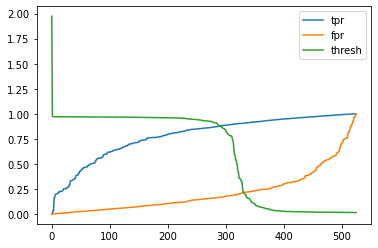

In [ ]:
plt.plot(tpr,label='tpr')
plt.plot(fpr,label='fpr')
plt.plot(threshs,label='thresh')
plt.legend()

###Итоги.

Сравнение всех моделей
1. accuracy:

* $\textbf{Предтренированный glove + классические модели(sklearn,catboost)}$ - самый простой способ, в то же время даёт accuracy сравнимый с более изощрёнными подходами. Логистическая регрессия дает 72.5% точность, СВМ - 73%, Бустинг - 72%

* $\textbf{Обучаемый слой эмбеддингов + рекуррентная нейронная сеть + полносвязный слой на выходе}$ - один из классических подходов к обработке последовательности дает accuracy 75.5%, при использовании предобученных векторов(navec) для слоя эмбеддингов, accuracy повышается до 79%.

* $\textbf{Bert(для получения эмбеддинга последовательности) + классификатор}$ - наиболее продвинутый подход, при использовании логистической регрессии в качестве классификатора удалось получить accuracy 72.6%, при использовании полносвязной нейронной сети удалось повысить accuracy до 86%. При этом у Берта просто сказочно красивый roc auc 

2. inference time(проверяется на всём датасете)

* $\textbf{Предтренированный glove + SVC}$ = 90 sec

* $\textbf{Обучаемый слой эмбеддингов + рекуррентная нейронная сеть + полносвязный слой на выходе}$ = 63 sec

* $\textbf{Bert(для получения эмбеддинга последовательности) + классификатор(полносвязный)}$ = 95 sec 



* Неудачи

Особо неудачных экспериментов не было, изначально планировал попробовать как раз эти 3 подхода. Предполагал что первый подход будет работать быстрее, но это оказалось не так. А ещё думал что бустинг будет лучше чем СВМ и это тоже оказалось не так.


$\textbf{Из интересного}$ то, что при развертывании сначала хотел проверить наиболее простой подход(1ый) и развернул его. Далее в экспериментах Bert давал прирост всего в 1-2%, поэтому решил развернуть рекуррентную сеть и думал уже так сдавать задачу, но что-то решил ещё немного поэкспериментировать, а так же посмотрел roc auc и в итоге пришёл к тому, что у Берта уже 86% accuracy и хороший roc auc(то есть при том, что почти все сэмплы из positive класса обнаружены, у нас еще и очень малое число negative сэмплов было определено как positive)

А так же пробовал сделать рекуррентную модель bidirectional и с 2 слоями, но на качестве это никак не сказалось

p.s. если интересует развертывание оставшихся 2 подходов, то могу и ими поделиться =)



### Final choice

В качестве финальной модели мною был выбран $\textbf{BERT}$ т.к. хоть он и работает медленнее(0.0077 сек на 1 sample на GPU для BERT, против 0,0051 для rnn), всё же он показал более хороший результат.

Возможно, при необходимости очень быстрого inference есть смысл перейти на подход с rnn

Итоговую модель далее нужно:
1. Обернуть в класс
2. Развернуть модель как REST API
3. Предоставить инструкцию что нужно сделать чтобы развернуть апи модели у себя на компьютере 